## Compiling Master Data Set

In [71]:
# Import packages
import pandas as pd
import seaborn as sns
import sqlite3 as sq
import matplotlib.pyplot as plt
%matplotlib inline

# Add extra relevant packages below as needed: 
import shutil
import numpy as np
import os
import re

In [72]:
# Import TMDB Database and format
db = pd.read_csv('zippedData/tmdb.movies.csv.gz')
db['genre_ids'].replace([''], np.nan, inplace=True)

#Import TN Database
tn_budget_raw = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

#Combine TN and TMDB databases
result = pd.merge(tn_budget_raw, db, left_on='movie', right_on='original_title',how='inner')
result.drop(columns=['id_x','Unnamed: 0','genre_ids','id_y','original_title','title'], inplace=True)

# Unzip IMDB SQL to new folder repository
import zipfile
with zipfile.ZipFile("zippedData/im.db.zip", 'r') as zip_ref:
    zip_ref.extractall("temp/IMDB_sql")
    
db_file = 'temp/IMDB_sql/im.db'

# Initializing imdb SQL database
# Create a SQL connection to our SQLite database
con = sq.connect(db_file)


## Query database for relevant information
genre_reviews = pd.read_sql(""" SELECT genres, primary_title, start_year
                
                FROM movie_basics
                LEFT JOIN movie_ratings ON movie_ratings.movie_id = movie_basics.movie_id
                JOIN movie_akas ON movie_akas.movie_id = movie_basics.movie_id
                WHERE start_year >= 2015 and region = 'US'
                ORDER BY averagerating DESC

""", con)

# Remove NaN values from SQL database
genre_reviews.dropna(inplace = True)

# Combine CSV and SQL data and format
comb_data = pd.merge(result, genre_reviews, left_on='movie', right_on='primary_title',how='inner')
comb_data.drop(columns=['primary_title', 'release_date_x','release_date_y'], inplace=True)
comb_data.drop_duplicates(subset=['movie'], inplace=True, ignore_index=True)

# Convert production budgets into ints
comb_data['production_budget'] = comb_data['production_budget'].str.strip('$')
comb_data['production_budget'] = comb_data['production_budget'].str.replace(',','')
comb_data['production_budget'] = comb_data['production_budget'].astype(int)

#Convert domestic gross into ints
comb_data['domestic_gross'] = comb_data['domestic_gross'].str.strip('$')
comb_data['domestic_gross'] = comb_data['domestic_gross'].str.replace(',','')
comb_data['domestic_gross'] = comb_data['domestic_gross'].astype(int)

# Convert worldwide gross into ints
comb_data['worldwide_gross'] = comb_data['worldwide_gross'].str.strip('$')
comb_data['worldwide_gross'] = comb_data['worldwide_gross'].str.replace(',','')
comb_data['worldwide_gross'] = comb_data['worldwide_gross'].astype(int)

# Removing movies that made less than $25,000
comb_data = comb_data[(comb_data['worldwide_gross'] > 25000)]

# Create movie net columns
comb_data['worldwide_net'] = comb_data['worldwide_gross'] - comb_data['production_budget']
comb_data['domestic_net'] = comb_data['domestic_gross'] - comb_data['production_budget']

# Sort by worldwide net
comb_data.sort_values(by="worldwide_net", ascending=False, inplace=True, ignore_index=True)

#remove temporary files
con.close()
shutil.rmtree('temp/')

In [73]:
# Create new df with genre counts higher than n
df1 = comb_data[comb_data['genres'].map(comb_data['genres'].value_counts()) >= 15]

In [74]:
# Print master data frame
comb_data

,movie,production_budget,domestic_gross,worldwide_gross,original_language,popularity,vote_average,vote_count,genres,start_year,worldwide_net,domestic_net
0,Avengers: Infinity War,300000000,678815482,2048134200,en,80.773,8.3,13948,"Action,Adventure,Sci-Fi",2018,1748134200,378815482
1,Jurassic World,215000000,652270625,1648854864,en,20.709,6.6,14056,"Action,Adventure,Sci-Fi",2015,1433854864,437270625
2,Furious 7,190000000,353007020,1518722794,en,20.396,7.3,6538,"Action,Crime,Thriller",2015,1328722794,163007020
3,Black Panther,200000000,700059566,1348258224,en,2.058,5.1,11,"Action,Adventure,Sci-Fi",2018,1148258224,500059566
4,Jurassic World: Fallen Kingdom,170000000,417719760,1305772799,en,34.958,6.5,5995,"Action,Adventure,Sci-Fi",2018,1135772799,247719760
...,...,...,...,...,...,...,...,...,...,...,...,...
585,Turbulence,55000000,11532774,11532774,en,1.073,5.6,5,"Action,Drama,Thriller",2016,-43467226,-43467226
586,Blackhat,70000000,8005980,19665004,en,16.824,5.3,1165,"Action,Crime,Thriller",2015,-50334996,-61994020
587,Monster Trucks,125000000,33370166,61642798,en,8.827,5.9,414,"Action,Adventure,Comedy",2016,-63357202,-91629834
588,Air Strike,65000000,0,516279,en,6.971,3.9,56,"Action,Adventure,Drama",2018,-64483721,-65000000


In [75]:
# Print df1
df1

,movie,production_budget,domestic_gross,worldwide_gross,original_language,popularity,vote_average,vote_count,genres,start_year,worldwide_net,domestic_net
0,Avengers: Infinity War,300000000,678815482,2048134200,en,80.773,8.3,13948,"Action,Adventure,Sci-Fi",2018,1748134200,378815482
1,Jurassic World,215000000,652270625,1648854864,en,20.709,6.6,14056,"Action,Adventure,Sci-Fi",2015,1433854864,437270625
3,Black Panther,200000000,700059566,1348258224,en,2.058,5.1,11,"Action,Adventure,Sci-Fi",2018,1148258224,500059566
4,Jurassic World: Fallen Kingdom,170000000,417719760,1305772799,en,34.958,6.5,5995,"Action,Adventure,Sci-Fi",2018,1135772799,247719760
6,Minions,74000000,336045770,1160336173,en,9.338,6.4,7343,"Adventure,Animation,Comedy",2015,1086336173,262045770
...,...,...,...,...,...,...,...,...,...,...,...,...
573,Dragonfly,60000000,30063805,30063805,en,0.664,3.0,2,Drama,2016,-29936195,-29936195
579,Shanghai,50000000,46425,15505922,en,6.824,6.1,80,Drama,2016,-34494078,-49953575
582,Rock Dog,60000000,9420546,24148488,en,10.362,5.7,123,"Adventure,Animation,Comedy",2016,-35851512,-50579454
584,Live by Night,65000000,10378555,21774432,en,11.322,6.2,759,"Action,Crime,Drama",2016,-43225568,-54621445


In [76]:
df1['international_gross'] = df1.worldwide_gross - df1.domestic_gross

C:\Users\bjere\AppData\Local\Temp/ipykernel_42412/3110200244.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['international_gross'] = df1.worldwide_gross - df1.domestic_gross


In [77]:
def get_genre_avg(genre, metric):
    df1[genre + "_count"]= df1["genres"].str.count(genre, re.I)
    df2 = df1[(df1[genre+"_count"] == 1)]
    df2_avg = df2[metric].mean()
    df1.drop(columns=[genre+"_count"], inplace=True)
    return df2_avg

In [78]:
# Set dataframe
genres = ['Action','Adventure','Animation','Comedy','Crime','Drama','Fantasy','Horror','Mystery','Sci-Fi','Thriller']
int_gross_genre = []
for i in genres:
    int_gross_genre.append(get_genre_avg(i,'international_gross'))
    
dom_gross_genre = []
for i in genres:
    dom_gross_genre.append(get_genre_avg(i,'domestic_gross'))

dic = {'Genre': genres,
      'International Gross' : int_gross_genre,
      'Domestic Gross' : dom_gross_genre}

df = pd.DataFrame(dic)

C:\Users\bjere\AppData\Local\Temp/ipykernel_42412/1108340566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[genre + "_count"]= df1["genres"].str.count(genre, re.I)
C:\Users\bjere\anaconda\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [79]:
# Sort df by sum of gross revenue
df['total_gross'] = df['International Gross'] + df['Domestic Gross'] 
df_sort = df.sort_values('total_gross', ascending=False, ignore_index=True)
df_sort.drop(columns=['total_gross'], inplace=True)
df = df_sort

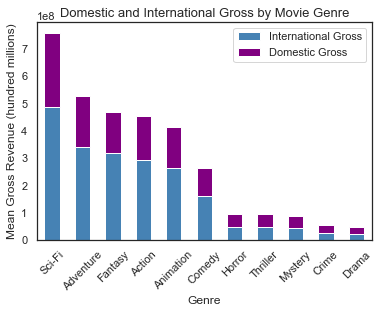

In [80]:
#set seaborn plotting aesthetics
sns.set(style='white')

#create stacked bar chart
df.set_index('Genre').plot(kind='bar', stacked=True, color=['steelblue', 'purple'])

#add overall title
plt.title('Domestic and International Gross by Movie Genre', fontsize=13)

#add axis titles
plt.xlabel('Genre')
plt.ylabel('Mean Gross Revenue (hundred millions)')

#remove scientific notation
plt.ticklabel_format(style='scientific', axis='y')
#plt.yticks(ax.get_yticks()//1000000)

#rotate x-axis labels
plt.xticks(rotation=45);

plt.savefig("./images/gross_rev_genre.png", dpi=150)

In [81]:
pop_genre = []
for i in genres:
    pop_genre.append(get_genre_avg(i,'popularity'))

C:\Users\bjere\AppData\Local\Temp/ipykernel_42412/1108340566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[genre + "_count"]= df1["genres"].str.count(genre, re.I)


In [82]:
# Sort by Pop Score
df_pop = pd.DataFrame({"Genre" : genres,
                   "Popularity" : pop_genre})
df_pop.sort_values("Popularity", inplace=True, ignore_index=True, ascending=False)

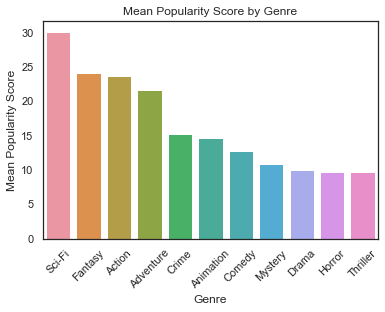

In [84]:
ax = sns.barplot(x="Genre", y="Popularity", data = df_pop)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_ylabel('Mean Popularity Score')
ax.set_title('Mean Popularity Score by Genre');

plt.savefig("./images/pop_score_genre.png", dpi=150)

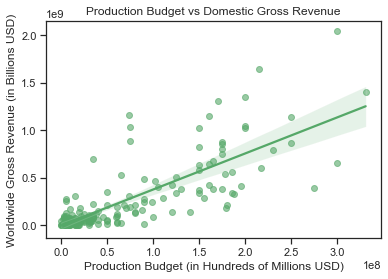

In [87]:
# Loading Elijah's regression graph
sns.set_style("ticks")
pvw = sns.regplot(x=df1['production_budget'], y=df1['worldwide_gross'],
                  data=df1, scatter_kws={'alpha':0.6 },
                 color="g", )
pvw.set(
    title="Production Budget vs Domestic Gross Revenue",
    xlabel ="Production Budget (in Hundreds of Millions USD)",
    ylabel ="Worldwide Gross Revenue (in Billions USD)",
    )
sns.set_style("whitegrid")

# Saving Elijah's regression graph to file
plt.savefig("./images/rev_budget_regression.png", dpi=150)

<Figure size 432x288 with 0 Axes>